In [1]:
%pylab inline
from astropy.io import fits as pyfits
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.io import fits
from astropy.table import Table,Column
import scipy.stats.distributions as dist

import os
import warnings
import requests

mpl.rcParams['text.usetex']=True
mpl.rcParams['axes.linewidth'] = 3

warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=UserWarning, append=True);

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load data from Dropbox folder instead of clogging up Github

def download_from_dropbox(url):
    
    local_filename = "../{:}".format(url.split("/")[-1].split("?")[0])
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                f.flush()
            
    return local_filename


In [3]:
#Load Data!
ferengi_filename = download_from_dropbox("https://www.dropbox.com/s/2dsnro4r5sa48gb/ferengi_all_weighted_and_meta.fits?dl=1")
data = Table.read(ferengi_filename) 

In [4]:
#Defining surface brightness bins
#yedges=np.linspace(np.min(data['mu_max_i']),np.max(data['mu_max_i']),10)

p_x = 't00_smooth_or_features_a1_features_frac_weighted_2' #p for question in question (lol)
N_x = 't00_smooth_or_features_count_weighted_2' #N for question in question (number of people who answered question) 
N_cut = 0 #number of people we require to get to question

red_data = data[(data['PETROMAG_U']-data['PETROMAG_R']<2)]
blue_data=data[(data['PETROMAG_U']-data['PETROMAG_R']>=2)]

#Pick out unique galaxies
galaxies = set(data['objid'])
red_galaxies = set(red_data['objid'])
blue_galaxies = set(blue_data['objid'])



In [73]:
#simulated redshifts of ferengi data:
reds=[.3,.4,.5,.6,.7,.8,.9,1]

#Defining lists of p_features at high and low (z=0.3) redshifts at given SB and redshifts. 
red_scatter_dct={}
for z in reds:
    for edge in yedges:
        red_scatter_dct[z,edge,'hi']=[]
        red_scatter_dct[z,edge,'lo']=[]
        red_scatter_dct[z,edge,'subj_id']=[]
        
for i,g in enumerate(red_galaxies):
    this_gal=(red_data['objid']==g)
    evos = set(red_data[this_gal]['sim_evolution'])
#    if 0 in evos:
#        evos.remove(0) #remove this line if including 0 evolution data
#    evos=[0]
    for e in evos:
        this_evo=(red_data[this_gal]['sim_evolution']==e)
        if len(set(red_data[this_gal][this_evo]['sim_redshift']))==8: #only want stuff where we have data down to 0.3
            p_at_3=(red_data[this_gal][this_evo]['sim_redshift']==.3)
            p_bar_at_3 = red_data[this_gal][this_evo][p_at_3][p_x][0]#value of p_x at redshift 0.3
            n_bar_at_3 = red_data[this_gal][this_evo][p_at_3][N_x][0] #number of people who answeredquestion for the 0.3 image
            if n_bar_at_3 >= N_cut: #only care about galaxies with at least N people answering question at 0.3
                for row in red_data[this_gal][this_evo]:
                    for y in range(0,len(yedges)-1):
                        for j,hi_z in enumerate(reds):
                            if round(row['sim_redshift'],2)==hi_z and row['mu_max_i'] > yedges[y] and row['mu_max_i'] < yedges[y+1] and row[N_x]>=N_cut: #now look at high redshift data ; only care if 5 people answerwed question
                                red_scatter_dct[hi_z,yedges[y],'hi'].append(row[p_x]) # slap p_x in high list 
                                red_scatter_dct[hi_z,yedges[y],'lo'].append(p_bar_at_3) # put z=0.3 value in low list 
     

In [89]:

#Defining lists of p_features at high and low (z=0.3) redshifts at given SB and redshifts. 
blue_scatter_dct={}
for z in reds:
    for edge in yedges:
        blue_scatter_dct[z,edge,'hi']=[]
        blue_scatter_dct[z,edge,'lo']=[]
        blue_scatter_dct[z,edge,'subj_id']=[]
        
for i,g in enumerate(blue_galaxies):
    this_gal=(blue_data['objid']==g)
    evos = set(blue_data[this_gal]['sim_evolution'])
#    if 0 in evos:
#        evos.remove(0) #remove this line if including 0 evolution data
#    evos=[0]
    for e in evos:
        this_evo=(blue_data[this_gal]['sim_evolution']==e)
        if len(set(blue_data[this_gal][this_evo]['sim_redshift']))==8: #only want stuff where we have data down to 0.3
            p_at_3=(blue_data[this_gal][this_evo]['sim_redshift']==.3)
            p_bar_at_3 = blue_data[this_gal][this_evo][p_at_3][p_x][0]#value of p_x at redshift 0.3
            n_bar_at_3 = blue_data[this_gal][this_evo][p_at_3][N_x][0] #number of people who answeredquestion for the 0.3 image
            if n_bar_at_3 >= N_cut: #only care about galaxies with at least N people answering question at 0.3
                for row in blue_data[this_gal][this_evo]:
                    for y in range(0,len(yedges)-1):
                        for j,hi_z in enumerate(reds):
                            if round(row['sim_redshift'],2)==hi_z and row['mu_max_i'] > yedges[y] and row['mu_max_i'] < yedges[y+1] and row[N_x]>=N_cut: #now look at high redshift data ; only care if 5 people answerwed question
                                blue_scatter_dct[hi_z,yedges[y],'hi'].append(row[p_x]) # slap p_x in high list 
                                blue_scatter_dct[hi_z,yedges[y],'lo'].append(p_bar_at_3) # put z=0.3 value in low list 
     

In [7]:
def derivative_of_poly(x_list,fit_cos,deg):
    if deg == 3:
        derivative=3*fit_cos[3]*x_list**2+2*fit_cos[2]*x_list+fit_cos[1]
    if deg == 2:
        derivative=2*fit_cos[2]*x_list+fit_cos[1]
    if deg ==1:
        derivative=fit_cos[1]


    return derivative

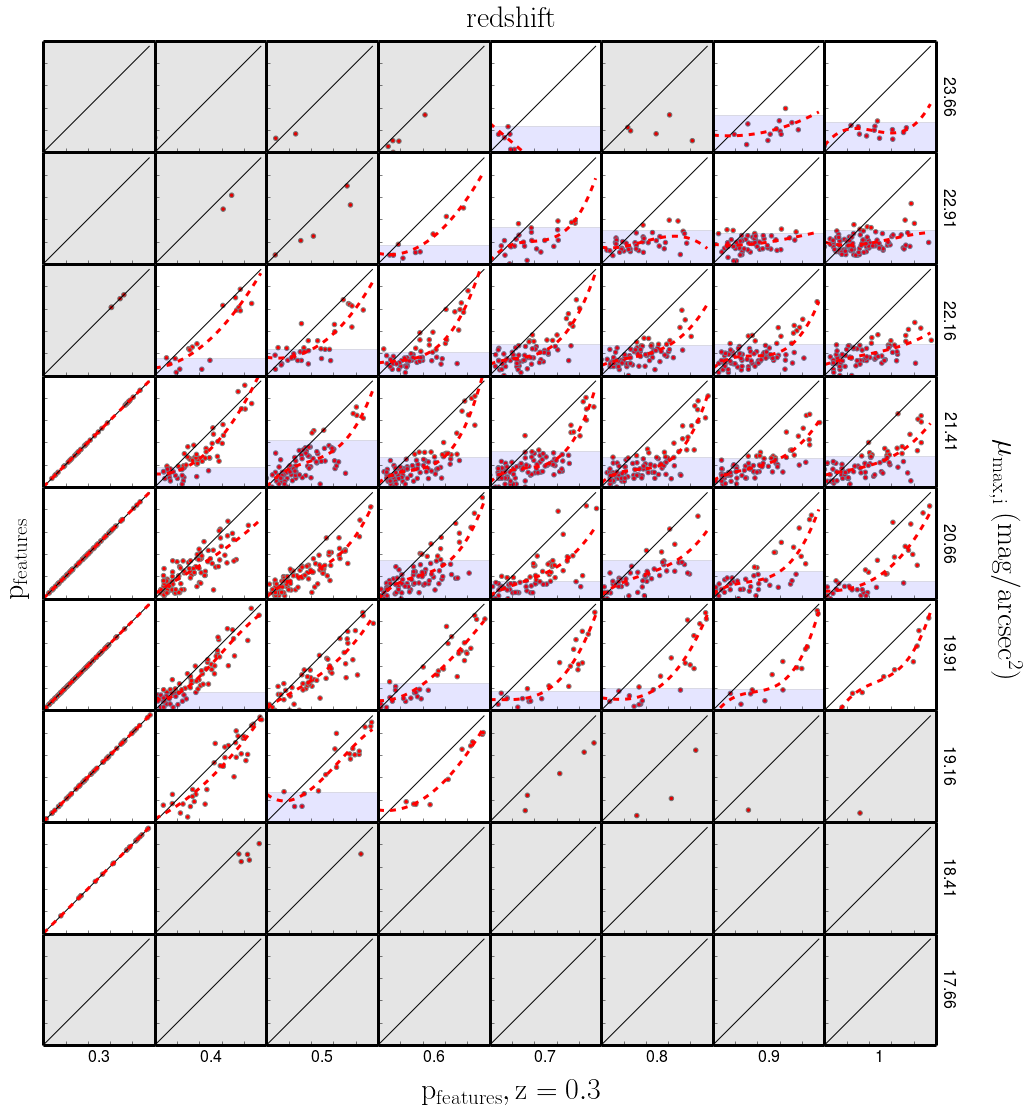

In [113]:
#Plot p_features at a given redshift vs p_features at z=0.3 at each redshift, binned by surface brightness
f=figure(figsize=(20,18))
#track 'uncorrectable' regions of z/mu/p space (shaded)
p_range_uncorrectable_dct={}
#track 'correctable regions of z/mu/p space (unshaded *and* at least 5 points in bin) 
p_range_correctable_dct={}
#store range of spread of data in each bin
interval_dct={}
x_new = np.linspace(0,.95,40)
slope_cut=.35

gs=gridspec.GridSpec(9,10)
gs.update(wspace=0)
gs.update(hspace=0)
yedge_int=[8,7,6,5,4,3,2,1,0]
y_label=[]
facecolors=['#af8dc3','#999999','#7fbf7b']
for i in range(0,len(yedges)-1):
    y_label.append(round((yedges[i]+yedges[i+1])/2,2))
    #y_label.append(round(yedges[i],1))
y_label=y_label[::-1]
for j,y in enumerate(yedge_int):
    for i,z in enumerate(reds):
        ax=plt.subplot(gs[j,i])
        xs=red_scatter_dct[z,yedges[y],'lo']
        ys=red_scatter_dct[z,yedges[y],'hi']
    #    xs_0=scatter_dct_0[z,yedges[y],'lo']
    #   ys_0=scatter_dct_0[z,yedges[y],'hi']
        plt.plot(x_new,x_new,c='k')
        flat_list=[]
        p_range_uncorrectable_dct[z,yedges[y]]=[]
        p_range_correctable_dct[z,yedges[y]]=[]
        plt.scatter(xs,ys,c='r',edgecolors='gray')
    #    plt.scatter(xs_0,ys_0,c='r',s=30)
        if len(xs)>5:
            poly_params=np.polynomial.polynomial.polyfit(xs,ys,3)
            poly = np.polynomial.Polynomial(poly_params)
            drv=derivative_of_poly(x_new,poly_params,3)
            if np.min(drv)>-1: #fit okay, go ahead and plot
                plt.plot(x_new,np.polyval(poly_params[::-1],x_new),c='r',lw=3,ls='dashed')
                for d,val in enumerate(drv):
                    if val < slope_cut:
                        #plt.axvline(x_new[d],lw=3,alpha=.1) #shade vertically 
                        flat_list.append(x_new[d]) #list of x-values for shaded region
                if len(flat_list)>0: # if there are bad regions, record stuff:
                    min_p_at_3=np.min(flat_list) #minimum x value of shaded region 
                    max_p_at_3=np.max(flat_list) #maximum x value of shaded region
                    
                    #get list of y values in shaded region
                    bad_p_at_z_list=[] 
                    for p_int,p in enumerate(xs): 
                        if p>=min_p_at_3 and p < max_p_at_3:
                            bad_p_at_z_list.append(ys[p_int])
                    #shade out 3 standard deviations above and below the mean of that area        
                    #min_val = np.mean(bad_p_at_z_list)-1.5*np.std(bad_p_at_z_list)
                    min_val = 0 #I think the minimum should be 0...because... 
                    if len(bad_p_at_z_list)>0: #need at least 1 pts to get mean and std
                        max_val = np.mean(bad_p_at_z_list)+1.5*np.std(bad_p_at_z_list)
                    else:
                        max_val=0
                    plt.axhspan(0,max_val,alpha=.1)
                    p_range_uncorrectable_dct[z,yedges[y]].append(0)
                    p_range_uncorrectable_dct[z,yedges[y]].append(max_val) 
                    p_range_correctable_dct[z,yedges[y]].append(max_val)
                    p_range_correctable_dct[z,yedges[y]].append(1)
                else: #if no bad regions, whole square is correctable.    
                    p_range_uncorrectable_dct[z,yedges[y]].append(0)
                    p_range_uncorrectable_dct[z,yedges[y]].append(0) 
                    p_range_correctable_dct[z,yedges[y]].append(0)
                    p_range_correctable_dct[z,yedges[y]].append(1)



            else: #if < 0, try 2nd order instead 
                poly_params=np.polynomial.polynomial.polyfit(xs,ys,2)
                poly = np.polynomial.Polynomial(poly_params)
                drv=derivative_of_poly(x_new,poly_params,2)
                if np.min(drv)>-1: #fit okay, go ahead and plot
                    plt.plot(x_new,np.polyval(poly_params[::-1],x_new),c='r',lw=3,ls='dashed')
                    for d,val in enumerate(drv):
                        if val < slope_cut:
                            #plt.axvline(x_new[d],lw=3,alpha=.1)
                            flat_list.append(x_new[d]) #list of x-values for shaded region
                    if len(flat_list)>0: # if there are bad regions, record stuff:
                        min_p_at_3=np.min(flat_list) #minimum x value of shaded region 
                        max_p_at_3=np.max(flat_list) #maximum x value of shaded region
                    
                        #get list of y values in shaded region
                        bad_p_at_z_list=[] 
                        for p_int,p in enumerate(xs): 
                            if p>=min_p_at_3 and p < max_p_at_3:
                                bad_p_at_z_list.append(ys[p_int])
                        #shade out 3 standard deviations around the mean of that area        
                        min_val=0
                        #min_val = np.mean(bad_p_at_z_list)-1.5*np.std(bad_p_at_z_list)
                        if len(bad_p_at_z_list)>0: #need at least 1 pts to get mean and std
                            max_val = np.mean(bad_p_at_z_list)+1.5*np.std(bad_p_at_z_list)
                        else:
                            max_val=0
                        plt.axhspan(min_val,max_val,alpha=.1)
                        p_range_uncorrectable_dct[z,yedges[y]].append(0)
                        p_range_uncorrectable_dct[z,yedges[y]].append(max_val) 
                        p_range_correctable_dct[z,yedges[y]].append(max_val)
                        p_range_correctable_dct[z,yedges[y]].append(1)
                    else: #if no bad regions, whole square is correctable.    
                        p_range_uncorrectable_dct[z,yedges[y]].append(0)
                        p_range_uncorrectable_dct[z,yedges[y]].append(0) 
                        p_range_correctable_dct[z,yedges[y]].append(0)
                        p_range_correctable_dct[z,yedges[y]].append(1)
                else: #fit still bad, do a linear
                    poly_params=np.polynomial.polynomial.polyfit(xs,ys,1)
                    poly = np.polynomial.Polynomial(poly_params)
                    plt.plot(x_new,np.polyval(poly_params[::-1],x_new),c='r',lw=3,ls='dashed')
                    drv=derivative_of_poly(x_new,poly_params,1)
                    if drv < slope_cut:
                            #plt.axvline(x_new[d],lw=3,alpha=.1)
                        flat_list=x_new #list of x-values for shaded region
                        min_p_at_3=np.min(flat_list) #minimum x value of shaded region 
                        max_p_at_3=np.max(flat_list) #maximum x value of shaded region
                    
                        #get list of y values in shaded region
                        bad_p_at_z_list=ys
                        min_val=0
                        #min_val = np.mean(bad_p_at_z_list)-1.5*np.std(bad_p_at_z_list)
                        if len(bad_p_at_z_list)>0: #need at least 1 pts to get mean and std
                            max_val = np.mean(bad_p_at_z_list)+1.5*np.std(bad_p_at_z_list)
                        else:
                            max_val=0
                        plt.axhspan(min_val,max_val,alpha=.1)
                        p_range_uncorrectable_dct[z,yedges[y]].append(0)
                        p_range_uncorrectable_dct[z,yedges[y]].append(max_val) 
                        p_range_correctable_dct[z,yedges[y]].append(max_val)
                        p_range_correctable_dct[z,yedges[y]].append(1)
                    else: #if no bad regions, whole square is correctable.    
                        p_range_uncorrectable_dct[z,yedges[y]].append(0)
                        p_range_uncorrectable_dct[z,yedges[y]].append(0) 
                        p_range_correctable_dct[z,yedges[y]].append(0)
                        p_range_correctable_dct[z,yedges[y]].append(1)

        
            plt.xlim(0,1)
            plt.ylim(0,1)
   
        else: #fewer than 5 points in square, so fuck it
            plt.axhspan(0,1,alpha=.1,color='k')
            plt.xlim(0,1)
            plt.ylim(0,1)
            p_range_uncorrectable_dct[z,yedges[y]].append(0)
            p_range_uncorrectable_dct[z,yedges[y]].append(0) 
            p_range_correctable_dct[z,yedges[y]].append(0)
            p_range_correctable_dct[z,yedges[y]].append(0)
            
        plt.tick_params(labelleft='off')
        plt.tick_params(top='off',right='off',labelbottom='off')

                
        if j==8:
            plt.xlabel('%s'%reds[i],fontsize=16)
        if i==7:
            ax.yaxis.set_label_position("right")
            plt.ylabel('%s'%str(y_label[j]).rjust(500),fontsize=16,rotation=270,labelpad=20)

f.text(.78,.5,r'$\mathrm{\mu_{max,i}~(mag/arcsec^2)}$',rotation=270,fontsize=30,va='center')
f.text(.45,.91,r'$\mathrm{redshift}$',fontsize=30,ha='center')
f.text(.1,.5,r'$\mathrm{p_{features}}$',rotation=90,fontsize=30,va='center')
f.text(.45,.08,r'$\mathrm{p_{features},z=0.3}$',fontsize=30,ha='center');

plt.savefig('red_ferengi.pdf')

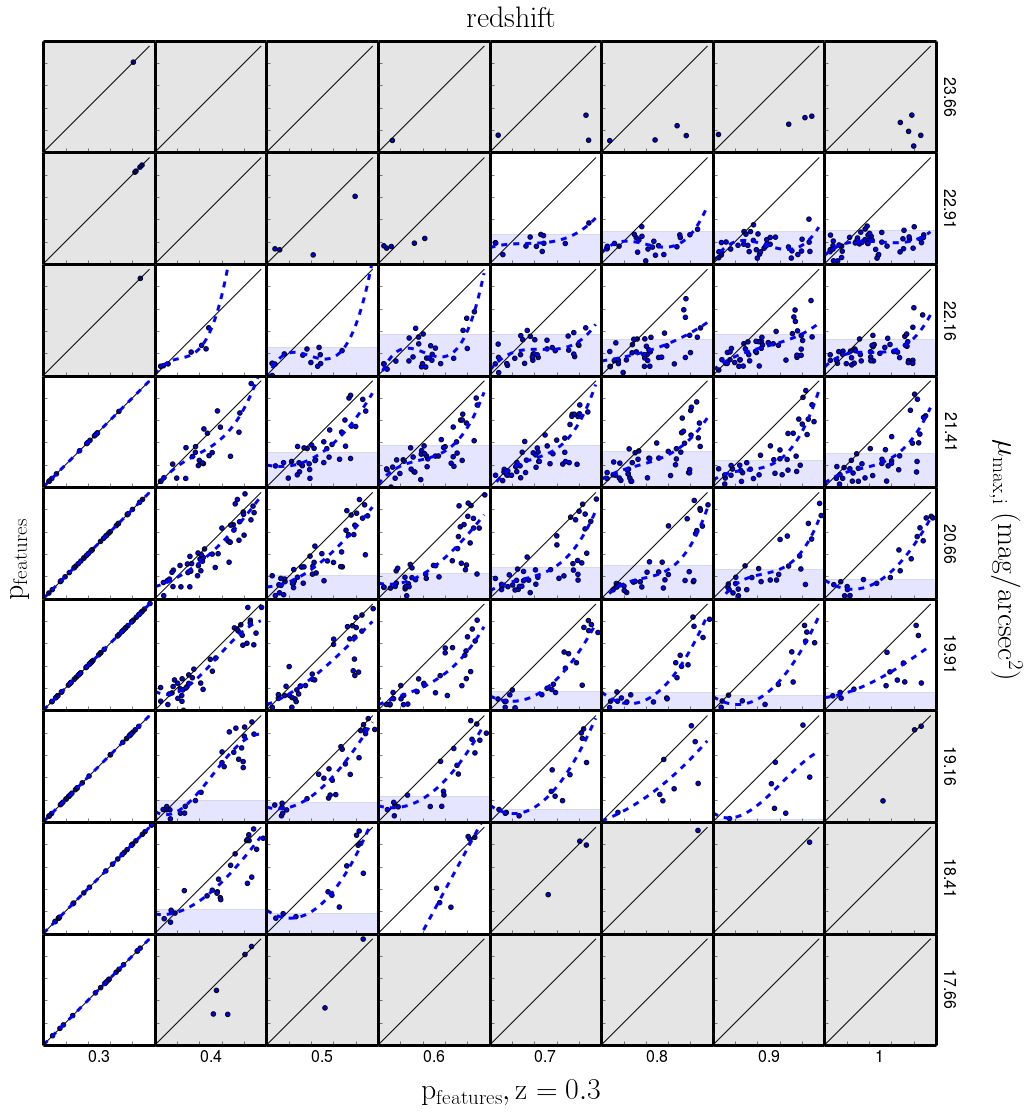

In [111]:
#Plot p_features at a given redshift vs p_features at z=0.3 at each redshift, binned by surface brightness
f=figure(figsize=(20,18))
#track 'uncorrectable' regions of z/mu/p space (shaded)
p_range_uncorrectable_dct={}
#track 'correctable regions of z/mu/p space (unshaded *and* at least 5 points in bin) 
p_range_correctable_dct={}
#store range of spread of data in each bin
interval_dct={}
x_new = np.linspace(0,.95,40)
slope_cut=.35

gs=gridspec.GridSpec(9,10)
gs.update(wspace=0)
gs.update(hspace=0)
yedge_int=[8,7,6,5,4,3,2,1,0]
y_label=[]
facecolors=['#af8dc3','#999999','#7fbf7b']
for i in range(0,len(yedges)-1):
    y_label.append(round((yedges[i]+yedges[i+1])/2,2))
    #y_label.append(round(yedges[i],1))
y_label=y_label[::-1]
for j,y in enumerate(yedge_int):
    for i,z in enumerate(reds):
        ax=plt.subplot(gs[j,i])
        xs=blue_scatter_dct[z,yedges[y],'lo']
        ys=blue_scatter_dct[z,yedges[y],'hi']
    #    xs_0=scatter_dct_0[z,yedges[y],'lo']
    #   ys_0=scatter_dct_0[z,yedges[y],'hi']
        plt.plot(x_new,x_new,c='k')
        flat_list=[]
        p_range_uncorrectable_dct[z,yedges[y]]=[]
        p_range_correctable_dct[z,yedges[y]]=[]
        plt.scatter(xs,ys,c='b')
    #    plt.scatter(xs_0,ys_0,c='r',s=30)
        if len(xs)>5:
            poly_params=np.polynomial.polynomial.polyfit(xs,ys,3)
            poly = np.polynomial.Polynomial(poly_params)
            drv=derivative_of_poly(x_new,poly_params,3)
            if np.min(drv)>-1: #fit okay, go ahead and plot
                plt.plot(x_new,np.polyval(poly_params[::-1],x_new),c='b',lw=3,ls='dashed')
                for d,val in enumerate(drv):
                    if val < slope_cut:
                        #plt.axvline(x_new[d],lw=3,alpha=.1) #shade vertically 
                        flat_list.append(x_new[d]) #list of x-values for shaded region
                if len(flat_list)>0: # if there are bad regions, record stuff:
                    min_p_at_3=np.min(flat_list) #minimum x value of shaded region 
                    max_p_at_3=np.max(flat_list) #maximum x value of shaded region
                    
                    #get list of y values in shaded region
                    bad_p_at_z_list=[] 
                    for p_int,p in enumerate(xs): 
                        if p>=min_p_at_3 and p < max_p_at_3:
                            bad_p_at_z_list.append(ys[p_int])
                    #shade out 3 standard deviations above and below the mean of that area        
                    #min_val = np.mean(bad_p_at_z_list)-1.5*np.std(bad_p_at_z_list)
                    min_val = 0 #I think the minimum should be 0...because... 
                    if len(bad_p_at_z_list)>0: #need at least 1 pts to get mean and std
                        max_val = np.mean(bad_p_at_z_list)+1.5*np.std(bad_p_at_z_list)
                    else:
                        max_val=0
                    if z==.4 and j ==5:
                        max_val=0
                    if z ==.4 and j == 6:
                        max_val = .2
                    plt.axhspan(0,max_val,alpha=.1)
                    p_range_uncorrectable_dct[z,yedges[y]].append(0)
                    p_range_uncorrectable_dct[z,yedges[y]].append(max_val) 
                    p_range_correctable_dct[z,yedges[y]].append(max_val)
                    p_range_correctable_dct[z,yedges[y]].append(1)
                else: #if no bad regions, whole square is correctable.    
                    p_range_uncorrectable_dct[z,yedges[y]].append(0)
                    p_range_uncorrectable_dct[z,yedges[y]].append(0) 
                    p_range_correctable_dct[z,yedges[y]].append(0)
                    p_range_correctable_dct[z,yedges[y]].append(1)



            else: #if < 0, try 2nd order instead 
                poly_params=np.polynomial.polynomial.polyfit(xs,ys,2)
                poly = np.polynomial.Polynomial(poly_params)
                drv=derivative_of_poly(x_new,poly_params,2)
                if np.min(drv)>-1: #fit okay, go ahead and plot
                    plt.plot(x_new,np.polyval(poly_params[::-1],x_new),c='b',lw=3,ls='dashed')
                    for d,val in enumerate(drv):
                        if val < slope_cut:
                            #plt.axvline(x_new[d],lw=3,alpha=.1)
                            flat_list.append(x_new[d]) #list of x-values for shaded region
                    if len(flat_list)>0: # if there are bad regions, record stuff:
                        min_p_at_3=np.min(flat_list) #minimum x value of shaded region 
                        max_p_at_3=np.max(flat_list) #maximum x value of shaded region
                    
                        #get list of y values in shaded region
                        bad_p_at_z_list=[] 
                        for p_int,p in enumerate(xs): 
                            if p>=min_p_at_3 and p < max_p_at_3:
                                bad_p_at_z_list.append(ys[p_int])
                        #shade out 3 standard deviations around the mean of that area        
                        min_val=0
                        #min_val = np.mean(bad_p_at_z_list)-1.5*np.std(bad_p_at_z_list)
                        if len(bad_p_at_z_list)>0: #need at least 1 pts to get mean and std
                            max_val = np.mean(bad_p_at_z_list)+1.5*np.std(bad_p_at_z_list)
                        else:
                            max_val=0
                        plt.axhspan(min_val,max_val,alpha=.1)
                        p_range_uncorrectable_dct[z,yedges[y]].append(0)
                        p_range_uncorrectable_dct[z,yedges[y]].append(max_val) 
                        p_range_correctable_dct[z,yedges[y]].append(max_val)
                        p_range_correctable_dct[z,yedges[y]].append(1)
                    else: #if no bad regions, whole square is correctable.    
                        p_range_uncorrectable_dct[z,yedges[y]].append(0)
                        p_range_uncorrectable_dct[z,yedges[y]].append(0) 
                        p_range_correctable_dct[z,yedges[y]].append(0)
                        p_range_correctable_dct[z,yedges[y]].append(1)
                else: #fit still bad, do a linear
                    poly_params=np.polynomial.polynomial.polyfit(xs,ys,1)
                    poly = np.polynomial.Polynomial(poly_params)
                    plt.plot(x_new,np.polyval(poly_params[::-1],x_new),c='b',lw=3,ls='dashed')
                    drv=derivative_of_poly(x_new,poly_params,1)
                    if drv < slope_cut:
                            #plt.axvline(x_new[d],lw=3,alpha=.1)
                        flat_list=x_new #list of x-values for shaded region
                        min_p_at_3=np.min(flat_list) #minimum x value of shaded region 
                        max_p_at_3=np.max(flat_list) #maximum x value of shaded region
                    
                        #get list of y values in shaded region
                        bad_p_at_z_list=ys
                        min_val=0
                        #min_val = np.mean(bad_p_at_z_list)-1.5*np.std(bad_p_at_z_list)
                        if len(bad_p_at_z_list)>0: #need at least 1 pts to get mean and std
                            max_val = np.mean(bad_p_at_z_list)+1.5*np.std(bad_p_at_z_list)
                        else:
                            max_val=0
                        plt.axhspan(min_val,max_val,alpha=.1)
                        p_range_uncorrectable_dct[z,yedges[y]].append(0)
                        p_range_uncorrectable_dct[z,yedges[y]].append(max_val) 
                        p_range_correctable_dct[z,yedges[y]].append(max_val)
                        p_range_correctable_dct[z,yedges[y]].append(1)
                    else: #if no bad regions, whole square is correctable.    
                        p_range_uncorrectable_dct[z,yedges[y]].append(0)
                        p_range_uncorrectable_dct[z,yedges[y]].append(0) 
                        p_range_correctable_dct[z,yedges[y]].append(0)
                        p_range_correctable_dct[z,yedges[y]].append(1)

        
            plt.xlim(0,1)
            plt.ylim(0,1)
   
        else: #fewer than 5 points in square, so fuck it
            plt.axhspan(0,1,alpha=.1,color='k')
            plt.xlim(0,1)
            plt.ylim(0,1)
            p_range_uncorrectable_dct[z,yedges[y]].append(0)
            p_range_uncorrectable_dct[z,yedges[y]].append(0) 
            p_range_correctable_dct[z,yedges[y]].append(0)
            p_range_correctable_dct[z,yedges[y]].append(0)
            
        plt.tick_params(labelleft='off')
        plt.tick_params(top='off',right='off',labelbottom='off')

                
        if j==8:
            plt.xlabel('%s'%reds[i],fontsize=16)
        if i==7:
            ax.yaxis.set_label_position("right")
            plt.ylabel('%s'%str(y_label[j]).rjust(500),fontsize=16,rotation=270,labelpad=20)

f.text(.78,.5,r'$\mathrm{\mu_{max,i}~(mag/arcsec^2)}$',rotation=270,fontsize=30,va='center')
f.text(.45,.91,r'$\mathrm{redshift}$',fontsize=30,ha='center')
f.text(.1,.5,r'$\mathrm{p_{features}}$',rotation=90,fontsize=30,va='center')
f.text(.45,.08,r'$\mathrm{p_{features},z=0.3}$',fontsize=30,ha='center');

plt.savefig('blue_ferengi.pdf')

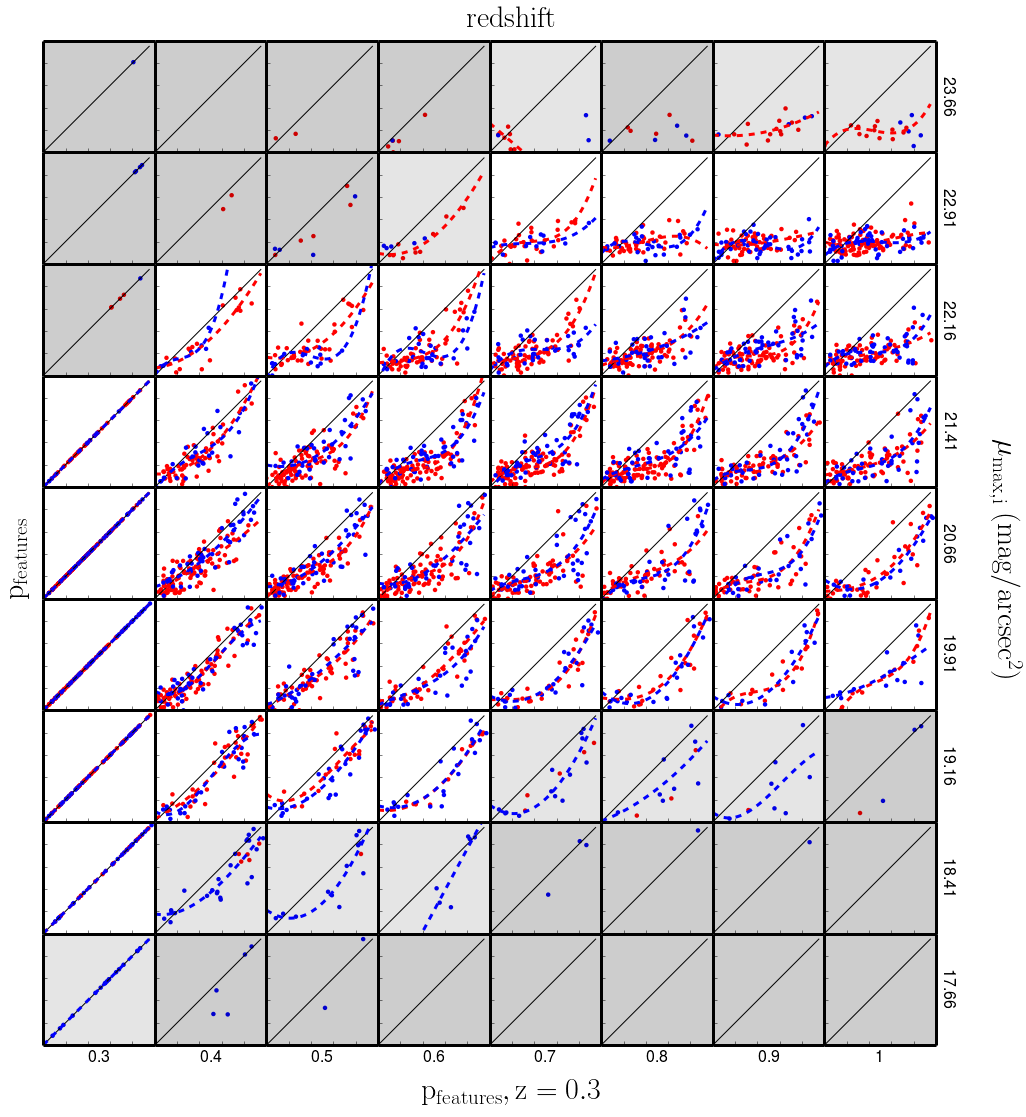

In [103]:
#Plot p_features at a given redshift vs p_features at z=0.3 at each redshift, binned by surface brightness
f=figure(figsize=(20,18))
#track 'uncorrectable' regions of z/mu/p space (shaded)
p_range_uncorrectable_dct={}
#track 'correctable regions of z/mu/p space (unshaded *and* at least 5 points in bin) 
p_range_correctable_dct={}
#store range of spread of data in each bin
interval_dct={}
x_new = np.linspace(0,.95,40)
slope_cut=.35

gs=gridspec.GridSpec(9,10)
gs.update(wspace=0)
gs.update(hspace=0)
yedge_int=[8,7,6,5,4,3,2,1,0]
y_label=[]
facecolors=['#af8dc3','#999999','#7fbf7b']
for i in range(0,len(yedges)-1):
    y_label.append(round((yedges[i]+yedges[i+1])/2,2))
    #y_label.append(round(yedges[i],1))
y_label=y_label[::-1]
for j,y in enumerate(yedge_int):
    for i,z in enumerate(reds):
        ax=plt.subplot(gs[j,i])
        red_xs=red_scatter_dct[z,yedges[y],'lo']
        red_ys=red_scatter_dct[z,yedges[y],'hi']
        blue_xs=blue_scatter_dct[z,yedges[y],'lo']
        blue_ys=blue_scatter_dct[z,yedges[y],'hi']
        plt.plot(x_new,x_new,c='k')
        flat_list=[]
        plt.scatter(red_xs,red_ys,c='r',edgecolors='none')
        plt.scatter(blue_xs,blue_ys,c='b',edgecolors='none')
    #    plt.scatter(xs_0,ys_0,c='r',s=30)
        if len(red_xs)>5:
            poly_params=np.polynomial.polynomial.polyfit(red_xs,red_ys,3)
            poly = np.polynomial.Polynomial(poly_params)
            drv=derivative_of_poly(x_new,poly_params,3)
            if np.min(drv)>-1: #fit okay, go ahead and plot
                plt.plot(x_new,np.polyval(poly_params[::-1],x_new),c='r',lw=3,ls='dashed')
                for d,val in enumerate(drv):
                    if val < slope_cut:
                        #plt.axvline(x_new[d],lw=3,alpha=.1) #shade vertically 
                        flat_list.append(x_new[d]) #list of x-values for shaded region
                if len(flat_list)>0: # if there are bad regions, record stuff:
                    min_p_at_3=np.min(flat_list) #minimum x value of shaded region 
                    max_p_at_3=np.max(flat_list) #maximum x value of shaded region
                    
                    #get list of y values in shaded region
                    bad_p_at_z_list=[] 
                    for p_int,p in enumerate(red_xs): 
                        if p>=min_p_at_3 and p < max_p_at_3:
                            bad_p_at_z_list.append(red_ys[p_int])
                    #shade out 3 standard deviations above and below the mean of that area        
                    #min_val = np.mean(bad_p_at_z_list)-1.5*np.std(bad_p_at_z_list)
                    min_val = 0 #I think the minimum should be 0...because... 
                    if len(bad_p_at_z_list)>0: #need at least 1 pts to get mean and std
                        max_val = np.mean(bad_p_at_z_list)+1.5*np.std(bad_p_at_z_list)
                    else:
                        max_val=0
                    #plt.axhspan(0,max_val,alpha=.1)



            else: #if < 0, try 2nd order instead 
                poly_params=np.polynomial.polynomial.polyfit(red_xs,red_ys,2)
                poly = np.polynomial.Polynomial(poly_params)
                drv=derivative_of_poly(x_new,poly_params,2)
                if np.min(drv)>-1: #fit okay, go ahead and plot
                    plt.plot(x_new,np.polyval(poly_params[::-1],x_new),c='r',lw=3,ls='dashed')
                    for d,val in enumerate(drv):
                        if val < slope_cut:
                            #plt.axvline(x_new[d],lw=3,alpha=.1)
                            flat_list.append(x_new[d]) #list of x-values for shaded region
                    if len(flat_list)>0: # if there are bad regions, record stuff:
                        min_p_at_3=np.min(flat_list) #minimum x value of shaded region 
                        max_p_at_3=np.max(flat_list) #maximum x value of shaded region
                    
                        #get list of y values in shaded region
                        bad_p_at_z_list=[] 
                        for p_int,p in enumerate(xs): 
                            if p>=min_p_at_3 and p < max_p_at_3:
                                bad_p_at_z_list.append(red_ys[p_int])
                        #shade out 3 standard deviations around the mean of that area        
                        min_val=0
                        #min_val = np.mean(bad_p_at_z_list)-1.5*np.std(bad_p_at_z_list)
                        if len(bad_p_at_z_list)>0: #need at least 1 pts to get mean and std
                            max_val = np.mean(bad_p_at_z_list)+1.5*np.std(bad_p_at_z_list)
                        else:
                            max_val=0
                        #plt.axhspan(min_val,max_val,alpha=.1)
                else: #fit still bad, do a linear
                    poly_params=np.polynomial.polynomial.polyfit(red_xs,red_ys,1)
                    poly = np.polynomial.Polynomial(poly_params)
                    plt.plot(x_new,np.polyval(poly_params[::-1],x_new),c='r',lw=3,ls='dashed')
                    drv=derivative_of_poly(x_new,poly_params,1)
                    if drv < slope_cut:
                            #plt.axvline(x_new[d],lw=3,alpha=.1)
                        flat_list=x_new #list of x-values for shaded region
                        min_p_at_3=np.min(flat_list) #minimum x value of shaded region 
                        max_p_at_3=np.max(flat_list) #maximum x value of shaded region
                    
                        #get list of y values in shaded region
                        bad_p_at_z_list=red_ys
                        min_val=0
                        #min_val = np.mean(bad_p_at_z_list)-1.5*np.std(bad_p_at_z_list)
                        if len(bad_p_at_z_list)>0: #need at least 1 pts to get mean and std
                            max_val = np.mean(bad_p_at_z_list)+1.5*np.std(bad_p_at_z_list)
                        else:
                            max_val=0
                        #plt.axhspan(min_val,max_val,alpha=.1)

        
            plt.xlim(0,1)
            plt.ylim(0,1)
   
        else: #fewer than 5 points in square, so fuck it
            plt.axhspan(0,1,alpha=.1,color='k')
            plt.xlim(0,1)
            plt.ylim(0,1)
        plt.tick_params(labelleft='off')
        plt.tick_params(top='off',right='off',labelbottom='off')
        
        if len(blue_xs)>5:
            poly_params=np.polynomial.polynomial.polyfit(blue_xs,blue_ys,3)
            poly = np.polynomial.Polynomial(poly_params)
            drv=derivative_of_poly(x_new,poly_params,3)
            if np.min(drv)>-1: #fit okay, go ahead and plot
                plt.plot(x_new,np.polyval(poly_params[::-1],x_new),c='b',lw=3,ls='dashed')
                for d,val in enumerate(drv):
                    if val < slope_cut:
                        #plt.axvline(x_new[d],lw=3,alpha=.1) #shade vertically 
                        flat_list.append(x_new[d]) #list of x-values for shaded region
                if len(flat_list)>0: # if there are bad regions, record stuff:
                    min_p_at_3=np.min(flat_list) #minimum x value of shaded region 
                    max_p_at_3=np.max(flat_list) #maximum x value of shaded region
                    
                    #get list of y values in shaded region
                    bad_p_at_z_list=[] 
                    for p_int,p in enumerate(blue_xs): 
                        if p>=min_p_at_3 and p < max_p_at_3:
                            bad_p_at_z_list.append(blue_ys[p_int])
                    #shade out 3 standard deviations above and below the mean of that area        
                    #min_val = np.mean(bad_p_at_z_list)-1.5*np.std(bad_p_at_z_list)
                    min_val = 0 #I think the minimum should be 0...because... 
                    if len(bad_p_at_z_list)>0: #need at least 1 pts to get mean and std
                        max_val = np.mean(bad_p_at_z_list)+1.5*np.std(bad_p_at_z_list)
                    else:
                        max_val=0
                    #plt.axhspan(0,max_val,alpha=.1)



            else: #if < 0, try 2nd order instead 
                poly_params=np.polynomial.polynomial.polyfit(blue_xs,blue_ys,2)
                poly = np.polynomial.Polynomial(poly_params)
                drv=derivative_of_poly(x_new,poly_params,2)
                if np.min(drv)>-1: #fit okay, go ahead and plot
                    plt.plot(x_new,np.polyval(poly_params[::-1],x_new),c='b',lw=3,ls='dashed')
                    for d,val in enumerate(drv):
                        if val < slope_cut:
                            #plt.axvline(x_new[d],lw=3,alpha=.1)
                            flat_list.append(x_new[d]) #list of x-values for shaded region
                    if len(flat_list)>0: # if there are bad regions, record stuff:
                        min_p_at_3=np.min(flat_list) #minimum x value of shaded region 
                        max_p_at_3=np.max(flat_list) #maximum x value of shaded region
                    
                        #get list of y values in shaded region
                        bad_p_at_z_list=[] 
                        for p_int,p in enumerate(xs): 
                            if p>=min_p_at_3 and p < max_p_at_3:
                                bad_p_at_z_list.append(blue_ys[p_int])
                        #shade out 3 standard deviations around the mean of that area        
                        min_val=0
                        #min_val = np.mean(bad_p_at_z_list)-1.5*np.std(bad_p_at_z_list)
                        if len(bad_p_at_z_list)>0: #need at least 1 pts to get mean and std
                            max_val = np.mean(bad_p_at_z_list)+1.5*np.std(bad_p_at_z_list)
                        else:
                            max_val=0
                        #plt.axhspan(min_val,max_val,alpha=.1)
                else: #fit still bad, do a linear
                    poly_params=np.polynomial.polynomial.polyfit(blue_xs,blue_ys,1)
                    poly = np.polynomial.Polynomial(poly_params)
                    plt.plot(x_new,np.polyval(poly_params[::-1],x_new),c='b',lw=3,ls='dashed')
                    drv=derivative_of_poly(x_new,poly_params,1)
                    if drv < slope_cut:
                            #plt.axvline(x_new[d],lw=3,alpha=.1)
                        flat_list=x_new #list of x-values for shaded region
                        min_p_at_3=np.min(flat_list) #minimum x value of shaded region 
                        max_p_at_3=np.max(flat_list) #maximum x value of shaded region
                    
                        #get list of y values in shaded region
                        bad_p_at_z_list=blue_ys
                        min_val=0
                        #min_val = np.mean(bad_p_at_z_list)-1.5*np.std(bad_p_at_z_list)
                        if len(bad_p_at_z_list)>0: #need at least 1 pts to get mean and std
                            max_val = np.mean(bad_p_at_z_list)+1.5*np.std(bad_p_at_z_list)
                        else:
                            max_val=0
                        #plt.axhspan(min_val,max_val,alpha=.1)

        
            plt.xlim(0,1)
            plt.ylim(0,1)
   
        else: #fewer than 5 points in square, so fuck it
            plt.axhspan(0,1,alpha=.1,color='k')
            plt.xlim(0,1)
            plt.ylim(0,1)
            
        plt.tick_params(labelleft='off')
        plt.tick_params(top='off',right='off',labelbottom='off')

                
        if j==8:
            plt.xlabel('%s'%reds[i],fontsize=16)
        if i==7:
            ax.yaxis.set_label_position("right")
            plt.ylabel('%s'%str(y_label[j]).rjust(500),fontsize=16,rotation=270,labelpad=20)

f.text(.78,.5,r'$\mathrm{\mu_{max,i}~(mag/arcsec^2)}$',rotation=270,fontsize=30,va='center')
f.text(.45,.91,r'$\mathrm{redshift}$',fontsize=30,ha='center')
f.text(.1,.5,r'$\mathrm{p_{features}}$',rotation=90,fontsize=30,va='center')
f.text(.45,.08,r'$\mathrm{p_{features},z=0.3}$',fontsize=30,ha='center');

plt.savefig('ferengi_red_and_blue.pdf')

In [5]:
#Defining surface brightness bins
#yedges=np.linspace(np.min(data['mu_max_i']),np.max(data['mu_max_i']),10)

#p_x = 't00_smooth_or_features_a1_features_frac_weighted_2' #p for question in question (lol)
p_x = 'p_features_best'
N_x = 't00_smooth_or_features_count_weighted_2' #N for question in question (number of people who answered question) 
N_cut = 0 #number of people we require to get to question

red_data = data[(data['PETROMAG_U']-data['PETROMAG_R']<2)]
blue_data=data[(data['PETROMAG_U']-data['PETROMAG_R']>=2)]

#Pick out unique galaxies
galaxies = set(data['objid'])
red_galaxies = set(red_data['objid'])
blue_galaxies = set(blue_data['objid'])

In [64]:
#simulated redshifts of ferengi data:
reds=[.3,.4,.5,.6,.7,.8,.9,1]

#Defining lists of p_features at high and low (z=0.3) redshifts at given SB and redshifts. 
red_scatter_dct={}
for z in reds:
    for edge in yedges:
        red_scatter_dct[z,edge,'hi']=[]
        red_scatter_dct[z,edge,'lo']=[]
        red_scatter_dct[z,edge,'subj_id']=[]
        
for i,g in enumerate(red_galaxies):
    this_gal=(red_data['objid']==g)
    evos = set(red_data[this_gal]['sim_evolution'])
#    if 0 in evos:
#        evos.remove(0) #remove this line if including 0 evolution data
#    evos=[0]
    for e in evos:
        this_evo=(red_data[this_gal]['sim_evolution']==e)
        if len(set(red_data[this_gal][this_evo]['sim_redshift']))==8: #only want stuff where we have data down to 0.3
            p_at_3=(red_data[this_gal][this_evo]['sim_redshift']==.3)
            p_bar_at_3 = red_data[this_gal][this_evo][p_at_3][p_x][0]#value of p_x at redshift 0.3
            n_bar_at_3 = red_data[this_gal][this_evo][p_at_3][N_x][0] #number of people who answeredquestion for the 0.3 image
            if n_bar_at_3 >= N_cut: #only care about galaxies with at least N people answering question at 0.3
                for row in red_data[this_gal][this_evo]:
                    for y in range(0,len(yedges)-1):
                        for j,hi_z in enumerate(reds):
                            if round(row['sim_redshift'],2)==hi_z and row['mu_max_i'] > yedges[y] and row['mu_max_i'] < yedges[y+1] and row[N_x]>=N_cut: #now look at high redshift data ; only care if 5 people answerwed question
                                red_scatter_dct[hi_z,yedges[y],'hi'].append(row[p_x]) # slap p_x in high list 
                                red_scatter_dct[hi_z,yedges[y],'lo'].append(p_bar_at_3) # put z=0.3 value in low list 
     

157

# Measuring fraction completeness as a function of redshift, surface brightness, color

In [6]:
yedges=np.linspace(np.min(data['mu_max_i']),np.max(data['mu_max_i']),7)
yedges=[round(y,2) for y in yedges]

xedges=np.linspace(np.min(data['sim_redshift'])-.05,np.max(data['sim_redshift'])+.05,5)
xedges=[round(x,2) for x in xedges]

In [7]:
red_scatter_dct={}
for i in range(0,len(xedges)-1):
    for j in range(0,len(yedges)-1):
        red_scatter_dct[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'hi']=[]
        red_scatter_dct[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'lo']=[]
        red_scatter_dct[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'subj_id']=[]
        
red_scatter_dct_unc={}
for i in range(0,len(xedges)-1):
    for j in range(0,len(yedges)-1):
        red_scatter_dct_unc[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'hi']=[]
        red_scatter_dct_unc[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'lo']=[]
        red_scatter_dct_unc[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'subj_id']=[]

blue_scatter_dct={}
for i in range(0,len(xedges)-1):
    for j in range(0,len(yedges)-1):
        blue_scatter_dct[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'hi']=[]
        blue_scatter_dct[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'lo']=[]
        blue_scatter_dct[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'subj_id']=[]

all_scatter_dct={}
for i in range(0,len(xedges)-1):
    for j in range(0,len(yedges)-1):
        all_scatter_dct[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'hi']=[]
        all_scatter_dct[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'lo']=[]
        all_scatter_dct[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'subj_id']=[]

all_scatter_dct_unc={}
for i in range(0,len(xedges)-1):
    for j in range(0,len(yedges)-1):
        all_scatter_dct_unc[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'hi']=[]
        all_scatter_dct_unc[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'lo']=[]
        all_scatter_dct_unc[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'subj_id']=[]


In [8]:
p_x = 'p_features_best'


for i,g in enumerate(red_galaxies):
    this_gal=(red_data['objid']==g)
    evos = set(red_data[this_gal]['sim_evolution'])
    for e in evos:
        this_evo=(red_data[this_gal]['sim_evolution']==e)
        if round(np.min(list((set(red_data[this_gal][this_evo]['sim_redshift'])))),2)==0.3: #only want stuff where we have data down to 0.3
            p_at_3=(red_data[this_gal][this_evo]['sim_redshift']==.3)
            p_x_at_3 = red_data[this_gal][this_evo][p_at_3][p_x][0]#value of p_x at redshift 0.3
            n_x_at_3 = red_data[this_gal][this_evo][p_at_3][N_x][0] #number of people who answeredquestion for the 0.3 image
            if n_x_at_3 >= N_cut: #only care about galaxies with at least N people answering question at 0.3
                for row in red_data[this_gal][this_evo]:
                    for y in range(0,len(yedges)-1):
                        for x in range(0,len(xedges)-1):
                            if row['sim_redshift']>xedges[x] and row['sim_redshift'] < xedges[x+1] and row['mu_max_i'] > yedges[y] and row['mu_max_i'] < yedges[y+1] and row[N_x]>=N_cut: #now look at high redshift data ; only care if 5 people answerwed question
                                if row['Correctable_Category']=='correctable  ':
                                    red_scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'hi'].append(row[p_x]) # slap p_x in high list 
                                    red_scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'lo'].append(p_x_at_3) # put z=0.3 value in low list 
                                else:
                                    red_scatter_dct_unc[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'hi'].append(row[p_x]) # slap p_x in high list 
                                    red_scatter_dct_unc[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'lo'].append(p_x_at_3) # put z=0.3 value in low list 

                                
for i,g in enumerate(galaxies):
    this_gal=(data['objid']==g)
    evos = set(data[this_gal]['sim_evolution'])
    for e in evos:
        this_evo=(data[this_gal]['sim_evolution']==e)
        if round(np.min(list((set(data[this_gal][this_evo]['sim_redshift'])))),2)==0.3: #only want stuff where we have data down to 0.3
            p_at_3=(data[this_gal][this_evo]['sim_redshift']==.3)
            p_x_at_3 = data[this_gal][this_evo][p_at_3][p_x][0]#value of p_x at redshift 0.3
            n_x_at_3 = data[this_gal][this_evo][p_at_3][N_x][0] #number of people who answeredquestion for the 0.3 image
            if n_x_at_3 >= N_cut: #only care about galaxies with at least N people answering question at 0.3
                for row in data[this_gal][this_evo]:
                    for y in range(0,len(yedges)-1):
                        for x in range(0,len(xedges)-1):
                            if row['sim_redshift']>xedges[x] and row['sim_redshift'] < xedges[x+1] and row['mu_max_i'] > yedges[y] and row['mu_max_i'] < yedges[y+1] and row[N_x]>=N_cut: #now look at high redshift data ; only care if 5 people answerwed question
                                if row['Correctable_Category']=='correctable  ':
                                    all_scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'hi'].append(row[p_x]) # slap p_x in high list 
                                    all_scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'lo'].append(p_x_at_3) # put z=0.3 value in low list 
                                else:
                                    all_scatter_dct_unc[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'hi'].append(row[p_x]) # slap p_x in high list 
                                    all_scatter_dct_unc[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'lo'].append(p_x_at_3) # put z=0.3 value in low list 


In [88]:
data['Correctable_Category'][0]=='correctable  '

True

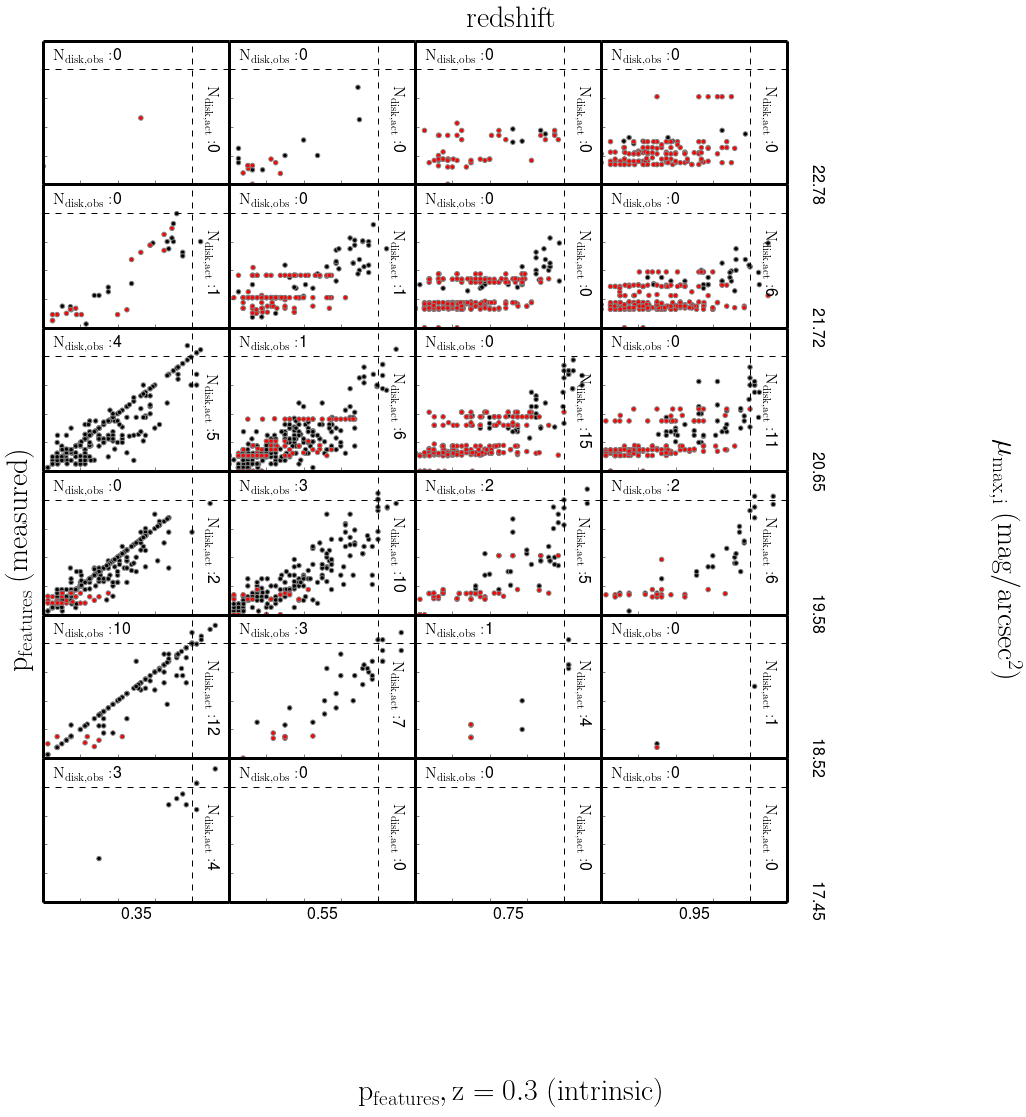

In [9]:
f=figure(figsize=(20,18))
#track 'uncorrectable' regions of z/mu/p space (shaded)
p_range_uncorrectable_dct={}
#track 'correctable regions of z/mu/p space (unshaded *and* at least 5 points in bin) 
p_range_correctable_dct={}
#store range of spread of data in each bin
interval_dct={}
x_new = np.linspace(0,.95,40)
slope_cut=.35

disk_cut = .8
red_completion_matrix = np.zeros(shape=(len(xedges)-1,len(yedges)-1))

gs=gridspec.GridSpec(len(yedges),len(xedges)+1)
gs.update(wspace=0)
gs.update(hspace=0)
yedge_int=np.linspace(0,len(yedges)-2,len(yedges)-1)
yedge_int=[int(y) for y in yedge_int]
yedge_int=yedge_int[::-1]
y_label=[]
x_label=[]
facecolors=['#af8dc3','#999999','#7fbf7b']
for i in range(0,len(yedges)-1):
    y_label.append(round((yedges[i]+yedges[i+1])/2,2))
    #y_label.append(round(yedges[i],1))
y_label=y_label[::-1]
for i in range(0,len(xedges)-1):
    x_label.append(round((xedges[i]+xedges[i+1])/2,2))

for y in range(0,len(yedges)-1):
    for x in range(0,len(xedges)-1):
        ax=plt.subplot(gs[yedge_int[y],x])
        xs=red_scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'lo']
        ys=red_scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'hi']
        xs_unc=red_scatter_dct_unc[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'lo']
        ys_unc=red_scatter_dct_unc[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'hi']

        plt.axhline(disk_cut,ls='dashed',c='k')
        plt.axvline(disk_cut,ls='dashed',c='k')
        #calculate number of observed disks
        #disks_observed = round(float(sum(i>=disk_cut for i in ys))/len(xs),2) if len(xs) > 10 else 'N/A'
        #disks_actual = round(float(sum(i>=disk_cut for i in xs))/len(xs),2) if len(xs) > 10 else 'N/A'
        disks_observed = sum(i>=disk_cut for i in ys) + sum(i>=disk_cut for i in ys_unc)
        disks_actual = sum(i>=disk_cut for i in xs) + sum(i>=disk_cut for i in xs_unc)

        red_completion_matrix.T[y,x]=(float(disks_observed)/disks_actual) if len(xs)>10 and disks_actual > 0 else 'nan'

        
        ax.text(.05,.85,'$\mathrm{N_{disk,obs}:}$%s'%disks_observed,fontsize=16)
        ax.text(.85,.6,'$\mathrm{N_{disk,act}:}$%s'%disks_actual,rotation=270,fontsize=16)
    #    xs_0=scatter_dct_0[z,yedges[y],'lo']
    #   ys_0=scatter_dct_0[z,yedges[y],'hi']
        #plt.plot(x_new,x_new,c='k')
        flat_list=[]
        plt.scatter(xs,ys,c='k',edgecolors='gray')
        plt.scatter(xs_unc,ys_unc,c='r',edgecolors='gray')

        plt.tick_params(labelleft='off')
        plt.tick_params(top='off',right='off',labelbottom='off')
        plt.xlim(0,1)
        plt.ylim(0,1)
        if y==0:
            plt.xlabel('%s'%str(x_label[x]),fontsize=16)

        if x==3:
            ax.yaxis.set_label_position("right")
            plt.ylabel('%s'%str(yedges[y]),fontsize=16,rotation=270)
            ax.yaxis.set_label_coords(1.2, 0)
    


f.text(.78,.5,r'$\mathrm{\mu_{max,i}~(mag/arcsec^2)}$',rotation=270,fontsize=30,va='center')
f.text(.45,.91,r'$\mathrm{redshift}$',fontsize=30,ha='center')
f.text(.1,.5,r'$\mathrm{p_{features}~(measured)}$',rotation=90,fontsize=30,va='center')
f.text(.45,.08,r'$\mathrm{p_{features},z=0.3~(intrinsic)}$',fontsize=30,ha='center')

plt.savefig('Images/red_ferengi_corrected_debiased.png')


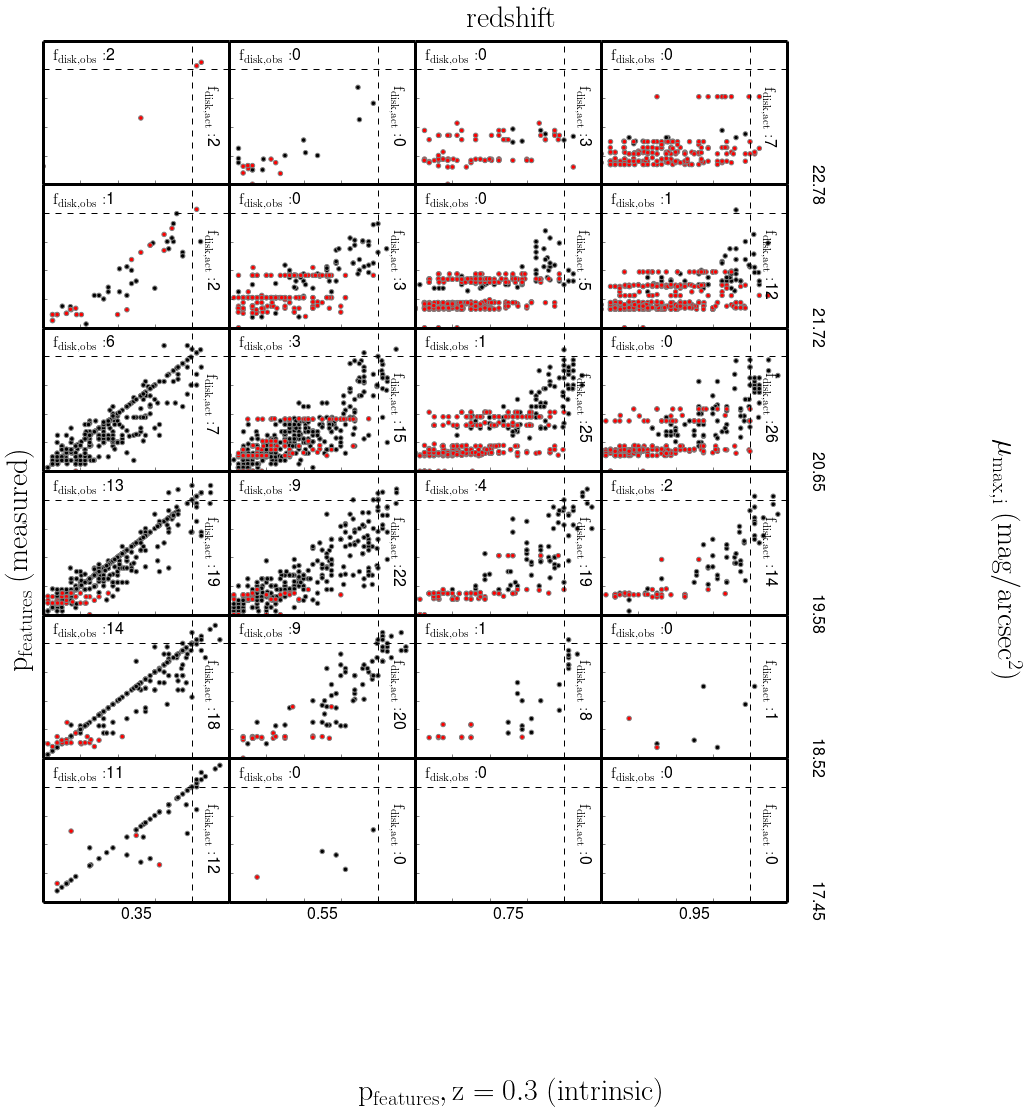

In [10]:
f=figure(figsize=(20,18))
#track 'uncorrectable' regions of z/mu/p space (shaded)
p_range_uncorrectable_dct={}
#track 'correctable regions of z/mu/p space (unshaded *and* at least 5 points in bin) 
p_range_correctable_dct={}
#store range of spread of data in each bin
interval_dct={}
x_new = np.linspace(0,.95,40)
slope_cut=.35

disk_cut = .8
all_completion_matrix = np.zeros(shape=(len(xedges)-1,len(yedges)-1))

gs=gridspec.GridSpec(len(yedges),len(xedges)+1)
gs.update(wspace=0)
gs.update(hspace=0)
yedge_int=np.linspace(0,len(yedges)-2,len(yedges)-1)
yedge_int=[int(y) for y in yedge_int]
yedge_int=yedge_int[::-1]
y_label=[]
x_label=[]
facecolors=['#af8dc3','#999999','#7fbf7b']
for i in range(0,len(yedges)-1):
    y_label.append(round((yedges[i]+yedges[i+1])/2,2))
    #y_label.append(round(yedges[i],1))
y_label=y_label[::-1]
for i in range(0,len(xedges)-1):
    x_label.append(round((xedges[i]+xedges[i+1])/2,2))

for y in range(0,len(yedges)-1):
    for x in range(0,len(xedges)-1):
        ax=plt.subplot(gs[yedge_int[y],x])
        xs=all_scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'lo']
        ys=all_scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'hi']
        xs_unc=all_scatter_dct_unc[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'lo']
        ys_unc=all_scatter_dct_unc[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'hi']

        
        plt.axhline(disk_cut,ls='dashed',c='k')
        plt.axvline(disk_cut,ls='dashed',c='k')
        #calculate number of observed disks
        disks_observed = sum(i>=disk_cut for i in ys) + sum(i>=disk_cut for i in ys_unc)
        disks_actual = sum(i>=disk_cut for i in xs) + sum(i>=disk_cut for i in xs_unc)
        all_completion_matrix.T[y,x]=(float(disks_observed)/disks_actual) if len(xs)>10 and disks_actual > 0 else 'nan'

        
        ax.text(.05,.85,'$\mathrm{f_{disk,obs}:}$%s'%disks_observed,fontsize=16)
        ax.text(.85,.6,'$\mathrm{f_{disk,act}:}$%s'%disks_actual,rotation=270,fontsize=16)
    #    xs_0=scatter_dct_0[z,yedges[y],'lo']
    #   ys_0=scatter_dct_0[z,yedges[y],'hi']
        #plt.plot(x_new,x_new,c='k')
        flat_list=[]
        plt.scatter(xs,ys,c='k',edgecolors='gray')
        plt.scatter(xs_unc,ys_unc,c='r',edgecolors='gray')

        plt.tick_params(labelleft='off')
        plt.tick_params(top='off',right='off',labelbottom='off')
        plt.xlim(0,1)
        plt.ylim(0,1)
        if y==0:
            plt.xlabel('%s'%str(x_label[x]),fontsize=16)

        if x==3:
            ax.yaxis.set_label_position("right")
            plt.ylabel('%s'%str(yedges[y]),fontsize=16,rotation=270)
            ax.yaxis.set_label_coords(1.2, 0)
  
                


f.text(.78,.5,r'$\mathrm{\mu_{max,i}~(mag/arcsec^2)}$',rotation=270,fontsize=30,va='center')
f.text(.45,.91,r'$\mathrm{redshift}$',fontsize=30,ha='center')
f.text(.1,.5,r'$\mathrm{p_{features}~(measured)}$',rotation=90,fontsize=30,va='center')
f.text(.45,.08,r'$\mathrm{p_{features},z=0.3~(intrinsic)}$',fontsize=30,ha='center');

plt.savefig('Images/all_ferengi_corrected_debiased.png')


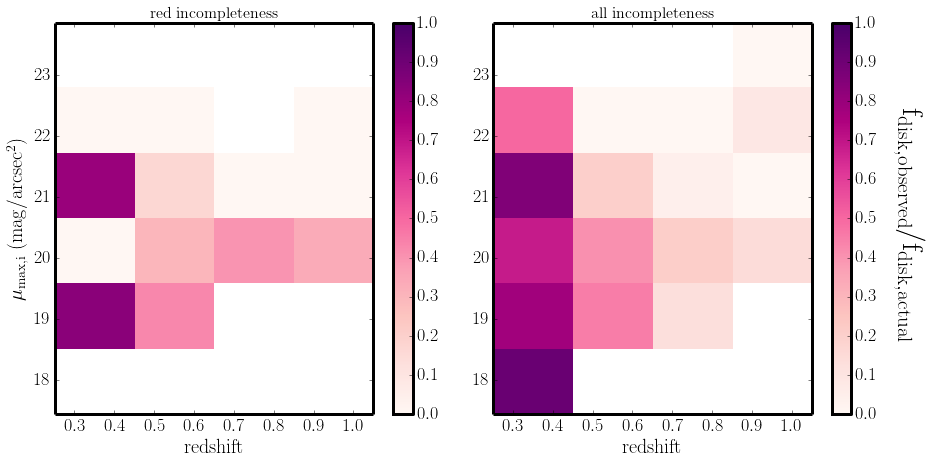

In [11]:
extent=[xedges[0],xedges[-1],yedges[0],yedges[-1]]
cmap=cm.RdPu
f=figure(figsize=(15,7))

mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18 

gs=gridspec.GridSpec(1,2)
gs.update(wspace=.1)

redax=plt.subplot(gs[0,0])
plt.imshow(red_completion_matrix.T,origin='lower',interpolation='nearest',vmin=0,vmax=1,extent=extent,aspect='auto',cmap=cmap)
plt.title('$\mathrm{red~incompleteness}$',fontsize=16)
plt.xlabel('$\mathrm{redshift}$',fontsize=20)

plt.ylabel(r'$\mathrm{\mu_{max,i}~(mag/arcsec^2)}$',fontsize=20)
plt.colorbar()


blueax=plt.subplot(gs[0,1])
plt.imshow(all_completion_matrix.T,origin='lower',interpolation='nearest',vmin=0,vmax=1,extent=extent,aspect='auto',cmap=cmap)
plt.colorbar()
plt.title('$\mathrm{all~incompleteness}$',fontsize=16)
plt.xlabel('$\mathrm{redshift}$',fontsize=20)

f.text(.9,.5,r'$\mathrm{f_{disk,observed}/f_{disk,actual}}$',rotation=270,fontsize=30,va='center')


## Now take Hubble galaxies, with red sequence defined from the red_disks notebook, and correct disk fraction in each redshift/surface brightness bin. 

In [12]:
hubble_data = pyfits.open('/home/mel/Documents/GZ_HUBBLE/other_catalogs/ULTRAVISTA/matched_catalog.fits')
hubble_data=hubble_data[1].data
z='Z_BEST_COMBINED'
data_2_1 = (hubble_data[z]>=.2) & (hubble_data[z]<=1) 
print 'The number of galaxies in COSMOS between $0.2 < z < 1.0$ is %s'%len(hubble_data[data_2_1])

#red_sequence = (hubble_data[z]>=0.2) & (hubble_data[z]<=1) & (hubble_data['MNUV']-hubble_data['MR']>(2.7-.077*hubble_data['MR'])) 
#blue_cloud = (hubble_data[z]>=0.2) & (hubble_data[z]<=1) & (hubble_data['MNUV']-hubble_data['MR']<(1.9-.077*hubble_data['MR'])) 

red_sequence = (hubble_data[z]>=0.2) & (hubble_data[z]<=1) & (hubble_data['MNUV']-hubble_data['MR']>3*(hubble_data['MR']-hubble_data['MJ'])+1) & (hubble_data['MNUV']-hubble_data['MR']>3) 
blue_cloud = (hubble_data[z]>=0.2) & (hubble_data[z]<=1) & ((hubble_data['MNUV']-hubble_data['MR']<3*(hubble_data['MR']-hubble_data['MJ'])+1) | (hubble_data['MNUV']-hubble_data['MR']<3)) 


print 'The number of red galaxies: %s'%len(hubble_data[red_sequence])
print 'The number of blue galaxies: %s'%len(hubble_data[blue_cloud])


The number of galaxies in COSMOS between $0.2 < z < 1.0$ is 52707
The number of red galaxies: 10340
The number of blue galaxies: 42366


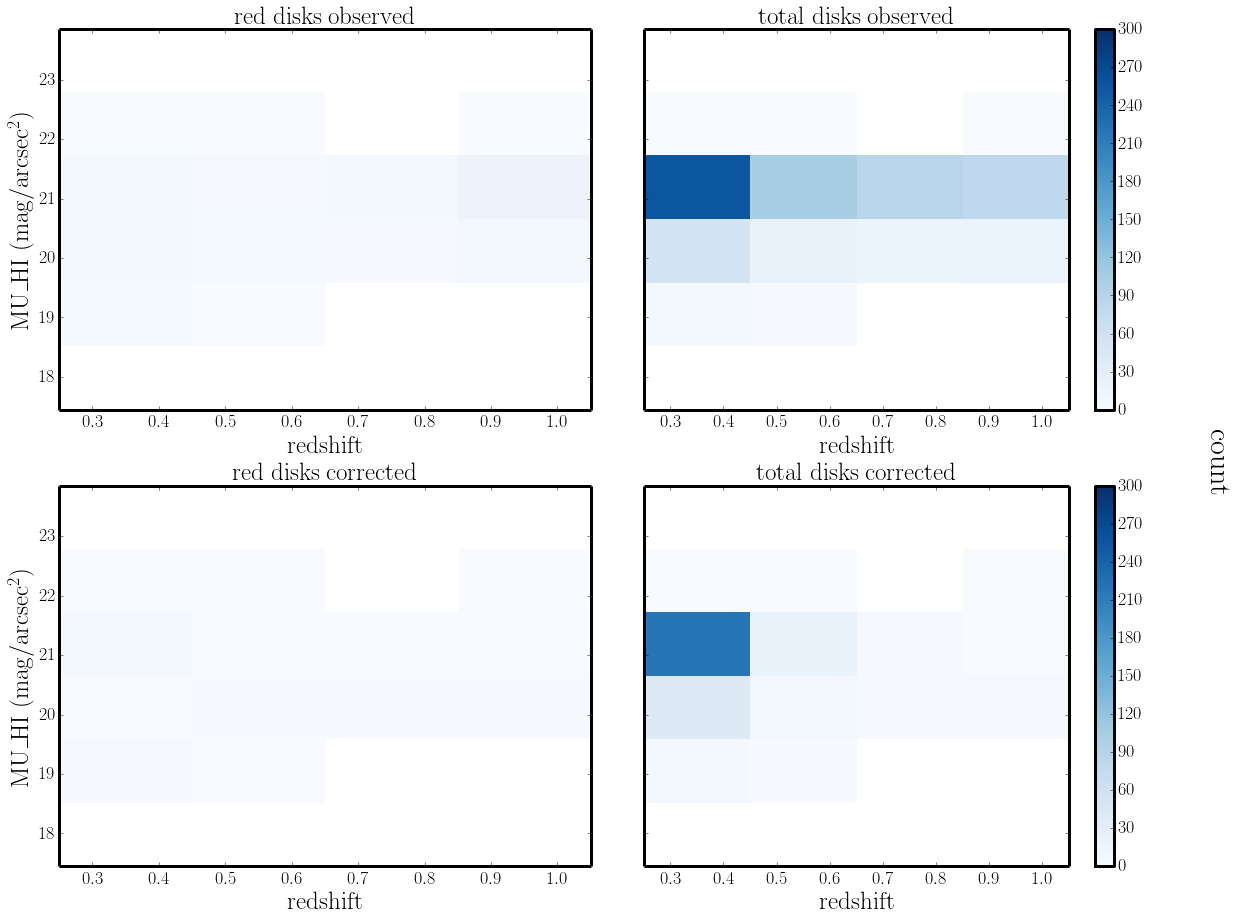

In [13]:
SB_cut = (hubble_data['MU_HI']<21.5)
xlabel = '$\mathrm{redshift}$'
ylabel = '$\mathrm{MU\_HI~(mag/arcsec^2)}$'

red_disks = red_sequence & SB_cut & (hubble_data['t01_smooth_or_features_a02_features_or_disk_best_fraction']>=disk_cut)
all_disks = SB_cut & (hubble_data['t01_smooth_or_features_a02_features_or_disk_best_fraction']>=disk_cut)

vmin=0
vmax=300

f=figure(figsize=(20,15))
gs=gridspec.GridSpec(2,2)
gs.update(wspace=.1)
gs.update(hspace=.2)



red_hist,xedges1,yedges1=np.histogram2d(hubble_data[red_disks][z],hubble_data[red_disks]['MU_HI'],range=((xedges[0],xedges[-1]),(yedges[0],yedges[-1])),bins=(len(xedges)-1,len(yedges)-1))
all_hist,xedges1,yedges1=np.histogram2d(hubble_data[all_disks][z],hubble_data[all_disks]['MU_HI'],range=((xedges[0],xedges[-1]),(yedges[0],yedges[-1])),bins=(len(xedges)-1,len(yedges)-1))
red_hist=np.ma.array(red_hist,mask=np.isnan(red_completion_matrix)==True)
all_hist=np.ma.array(all_hist,mask=np.isnan(red_completion_matrix)==True)


extent=[xedges1[0],xedges1[-1],yedges1[0],yedges1[-1]]

redax=plt.subplot(gs[0,0])
plt.imshow(red_hist.T,origin='lower',interpolation='nearest',extent=extent,aspect='auto',cmap=cm.Blues,vmin=vmin,vmax=vmax)
plt.title('$\mathrm{red~disks~observed}$',fontsize=25)
plt.ylabel(ylabel,fontsize=25)
plt.xlabel(xlabel,fontsize=25)


allax=plt.subplot(gs[0,1])
plt.imshow(all_hist.T,origin='lower',interpolation='nearest',extent=extent,aspect='auto',cmap=cm.Blues,vmin=vmin,vmax=vmax)
plt.title('$\mathrm{total~disks~observed}$',fontsize=25)
plt.tick_params(labelleft='off')
plt.xlabel(xlabel,fontsize=25)
plt.colorbar()

corrected_red_matrix = red_hist*red_completion_matrix
corrected_all_matrix = all_hist*all_completion_matrix


redax=plt.subplot(gs[1,0])
plt.imshow(corrected_red_matrix.T,origin='lower',interpolation='nearest',extent=extent,aspect='auto',cmap=cm.Blues,vmin=vmin,vmax=vmax)
plt.title('$\mathrm{red~disks~corrected}$',fontsize=25)
plt.ylabel(ylabel,fontsize=25)
plt.xlabel(xlabel,fontsize=25)


allax=plt.subplot(gs[1,1])
plt.imshow(corrected_all_matrix.T,origin='lower',interpolation='nearest',extent=extent,aspect='auto',cmap=cm.Blues,vmin=vmin,vmax=vmax)
plt.title('$\mathrm{total~disks~corrected}$',fontsize=25)
plt.tick_params(labelleft='off')
plt.xlabel(xlabel,fontsize=25)
plt.colorbar()


f.text(.92,.5,r'$\mathrm{count}$',rotation=270,fontsize=30,va='center')


In [14]:
def red_fraction_list(red_matrix,all_matrix):
    c=.95
    red_disk_fraction=[]
    N_red=[]
    N_all=[]
    yerr_low=[]
    yerr_hi=[]
    fraction_matrix = red_matrix/all_matrix
    for i in range(0,4):
        N_red_disks = np.nansum(red_matrix.T[:,i])
        N_all_disks = np.nansum(all_matrix.T[:,i])
        frac = N_red_disks/N_all_disks
        p_l=dist.beta.ppf((1-c)/2.,N_red_disks+1,N_all_disks-N_red_disks+1)
        p_u=dist.beta.ppf(1-(1-c)/2.,N_red_disks+1,N_all_disks-N_red_disks+1)
        yerr_low.append(frac-p_l)
        yerr_hi.append(p_u-frac)
        N_red.append(N_red_disks)
        N_all.append(N_all_disks)
        red_disk_fraction.append(frac)
    
    return red_disk_fraction,yerr_low,yerr_hi,N_red,N_all


In [15]:
f8,yl8,yh8,Nr,Na=red_fraction_list(red_hist,all_hist)
f8_c,yl8_c,yh8_c,Nr_c,Na_c=red_fraction_list(corrected_red_matrix,corrected_all_matrix)


In [181]:
#questions:
#is a surface brightness cut necessary if we're supposedly correcting for incompleteness at all levels?

#look at color distribution of galaxies at different redshift bins
#show stuff for different p_features, SB?
#redo errors for corrected galaxies
#pull up on stats - avg p_spiral, p_edgeon, p_merger, p_clumpy
#record fraction of red/blue disks taken out 

True

(0, 0.5)

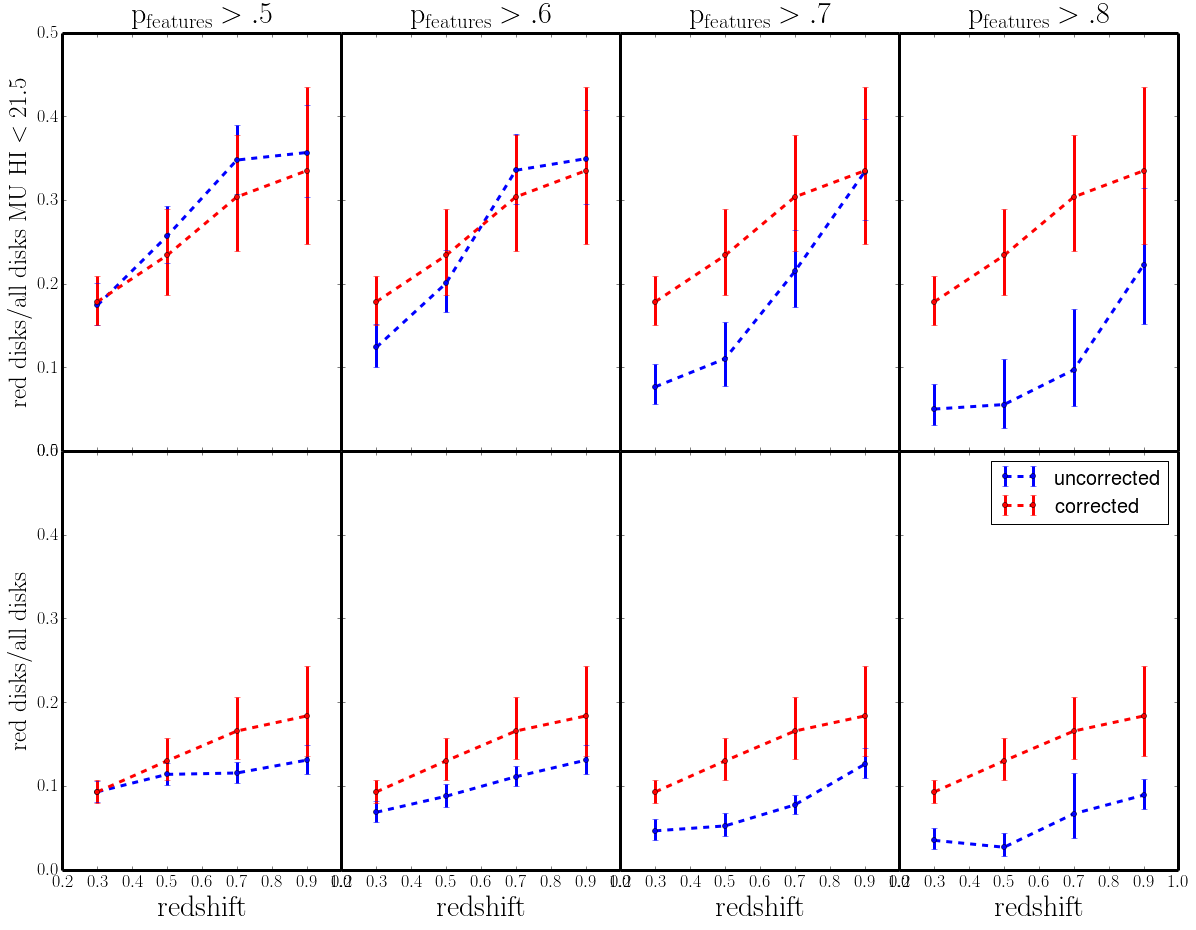

In [84]:


fig=figure(figsize=(20,15))
gs=gridspec.GridSpec(2,4)
gs.update(wspace=0)
gs.update(hspace=0)


ax1 = plt.subplot(gs[0,0])

f,yl,yh,Nr,Na=red_fraction_list(red_scatter_dct,red_scatter_dct_unc,all_scatter_dct,all_scatter_dct_unc,.5,21.5,'uncorrected')
f_c,yl_c,yh_c,Nr_c,Na_c=red_fraction_list(red_scatter_dct,red_scatter_dct_unc,all_scatter_dct,all_scatter_dct_unc,.5,21.5,'corrected')

plt.errorbar(reds,f,yerr=(yl,yh),c='b',fmt='--o',lw=3,ms=5,label='uncorrected')
plt.errorbar(reds,f_c,yerr=(yl_c,yh_c),c='r',fmt='--o',lw=3,ms=5,label='corrected')
plt.ylabel('$\mathrm{red~disks/all~disks~MU~HI<21.5}$',fontsize=25)
plt.tick_params(labelbottom='off')
plt.title('$\mathrm{p_{features}>.5}$',fontsize=30)
plt.xlim(.2,1)
plt.ylim(0,.5)

plt.subplot(gs[0,1],sharey=ax1)

f,yl,yh,Nr,Na=red_fraction_list(red_scatter_dct,red_scatter_dct_unc,all_scatter_dct,all_scatter_dct_unc,.6,21.5,'uncorrected')
f_c,yl_c,yh_c,Nr_c,Na_c=red_fraction_list(red_scatter_dct,red_scatter_dct_unc,all_scatter_dct,all_scatter_dct_unc,.5,21.5,'corrected')

plt.errorbar(reds,f,yerr=(yl,yh),c='b',fmt='--o',lw=3,ms=5,label='uncorrected')
plt.errorbar(reds,f_c,yerr=(yl_c,yh_c),c='r',fmt='--o',lw=3,ms=5,label='corrected')
plt.tick_params(labelleft='off',labelbottom='off')
plt.title('$\mathrm{p_{features}>.6}$',fontsize=30)
plt.xlim(.2,1)
plt.ylim(0,.5)

plt.subplot(gs[0,2],sharey=ax1)

f,yl,yh,Nr,Na=red_fraction_list(red_scatter_dct,red_scatter_dct_unc,all_scatter_dct,all_scatter_dct_unc,.7,21.5,'uncorrected')
f_c,yl_c,yh_c,Nr_c,Na_c=red_fraction_list(red_scatter_dct,red_scatter_dct_unc,all_scatter_dct,all_scatter_dct_unc,.5,21.5,'corrected')

plt.errorbar(reds,f,yerr=(yl,yh),c='b',fmt='--o',lw=3,ms=5,label='uncorrected')
plt.errorbar(reds,f_c,yerr=(yl_c,yh_c),c='r',fmt='--o',lw=3,ms=5,label='corrected')
plt.tick_params(labelleft='off',labelbottom='off')
plt.title('$\mathrm{p_{features}>.7}$',fontsize=30)
plt.xlim(.2,1)
plt.ylim(0,.5)


plt.subplot(gs[0,3],sharey=ax1)

f,yl,yh,Nr,Na=red_fraction_list(red_scatter_dct,red_scatter_dct_unc,all_scatter_dct,all_scatter_dct_unc,.8,21.5,'uncorrected')
f_c,yl_c,yh_c,Nr_c,Na_c=red_fraction_list(red_scatter_dct,red_scatter_dct_unc,all_scatter_dct,all_scatter_dct_unc,.5,21.5,'corrected')

plt.errorbar(reds,f,yerr=(yl,yh),c='b',fmt='--o',lw=3,ms=5,label='uncorrected')
plt.errorbar(reds,f_c,yerr=(yl_c,yh_c),c='r',fmt='--o',lw=3,ms=5,label='corrected')
plt.tick_params(labelleft='off',labelbottom='off')
plt.title('$\mathrm{p_{features}>.8}$',fontsize=30)
plt.xlim(.2,1)
plt.ylim(0,.5)



ax2 = plt.subplot(gs[1,0])

f,yl,yh,Nr,Na=red_fraction_list(red_scatter_dct,red_scatter_dct_unc,all_scatter_dct,all_scatter_dct_unc,.5,30,'uncorrected')
f_c,yl_c,yh_c,Nr_c,Na_c=red_fraction_list(red_scatter_dct,red_scatter_dct_unc,all_scatter_dct,all_scatter_dct_unc,.5,30,'corrected')

plt.errorbar(reds,f,yerr=(yl,yh),c='b',fmt='--o',lw=3,ms=5,label='uncorrected')
plt.errorbar(reds,f_c,yerr=(yl_c,yh_c),c='r',fmt='--o',lw=3,ms=5,label='corrected')
plt.xlabel('$\mathrm{redshift}$',fontsize=30)
plt.ylabel('$\mathrm{red~disks/all~disks}$',fontsize=25)
plt.xlim(.2,1)
plt.ylim(0,.5)

plt.subplot(gs[1,1],sharey=ax2)

f,yl,yh,Nr,Na=red_fraction_list(red_scatter_dct,red_scatter_dct_unc,all_scatter_dct,all_scatter_dct_unc,.6,30,'uncorrected')
f_c,yl_c,yh_c,Nr_c,Na_c=red_fraction_list(red_scatter_dct,red_scatter_dct_unc,all_scatter_dct,all_scatter_dct_unc,.5,30,'corrected')

plt.errorbar(reds,f,yerr=(yl,yh),c='b',fmt='--o',lw=3,ms=5,label='uncorrected')
plt.errorbar(reds,f_c,yerr=(yl_c,yh_c),c='r',fmt='--o',lw=3,ms=5,label='corrected')
plt.xlabel('$\mathrm{redshift}$',fontsize=30)
plt.tick_params(labelleft='off')
plt.xlim(.2,1)
plt.ylim(0,.5)


plt.subplot(gs[1,2],sharey=ax2)

f,yl,yh,Nr,Na=red_fraction_list(red_scatter_dct,red_scatter_dct_unc,all_scatter_dct,all_scatter_dct_unc,.7,30,'uncorrected')
f_c,yl_c,yh_c,Nr_c,Na_c=red_fraction_list(red_scatter_dct,red_scatter_dct_unc,all_scatter_dct,all_scatter_dct_unc,.5,30,'corrected')

plt.errorbar(reds,f,yerr=(yl,yh),c='b',fmt='--o',lw=3,ms=5,label='uncorrected')
plt.errorbar(reds,f_c,yerr=(yl_c,yh_c),c='r',fmt='--o',lw=3,ms=5,label='corrected')
plt.xlabel('$\mathrm{redshift}$',fontsize=30)
plt.tick_params(labelleft='off')
plt.xlim(.2,1)
plt.ylim(0,.5)


plt.subplot(gs[1,3],sharey=ax2)

f,yl,yh,Nr,Na=red_fraction_list(red_scatter_dct,red_scatter_dct_unc,all_scatter_dct,all_scatter_dct_unc,.8,30,'uncorrected')
f_c,yl_c,yh_c,Nr_c,Na_c=red_fraction_list(red_scatter_dct,red_scatter_dct_unc,all_scatter_dct,all_scatter_dct_unc,.5,30,'corrected')

plt.errorbar(reds,f,yerr=(yl,yh),c='b',fmt='--o',lw=3,ms=5,label='uncorrected')
plt.errorbar(reds,f_c,yerr=(yl_c,yh_c),c='r',fmt='--o',lw=3,ms=5,label='corrected')
plt.xlabel('$\mathrm{redshift}$',fontsize=30)
plt.tick_params(labelleft='off')
plt.legend(fontsize=20)
plt.xlim(.2,1)
plt.ylim(0,.5)


## Check properties of disk sample

In [72]:
def red_fraction_list(red_scatter_dct,red_scatter_dct_unc,all_scatter_dct,all_scatter_dct_unc,disk_cut,sb_cut,correct):
    
    #Get red matrix
    red_completion_matrix = np.zeros(shape=(len(xedges)-1,len(yedges)-1))
    for y in range(0,len(yedges)-1):
        for x in range(0,len(xedges)-1):
            xs=red_scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'lo']
            ys=red_scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'hi']
            xs_unc=red_scatter_dct_unc[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'lo']
            ys_unc=red_scatter_dct_unc[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'hi']

            disks_observed = sum(i>=disk_cut for i in ys) + sum(i>=disk_cut for i in ys_unc)
            disks_actual = sum(i>=disk_cut for i in xs) + sum(i>=disk_cut for i in xs_unc)

            red_completion_matrix.T[y,x]=(float(disks_observed)/disks_actual) if len(xs)>10 and disks_actual > 0 else 'nan'
    #Get all matrix
    for y in range(0,len(yedges)-1):
        for x in range(0,len(xedges)-1):
            xs=all_scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'lo']
            ys=all_scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'hi']
            xs_unc=all_scatter_dct_unc[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'lo']
            ys_unc=all_scatter_dct_unc[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'hi']

            disks_observed = sum(i>=disk_cut for i in ys) + sum(i>=disk_cut for i in ys_unc)
            disks_actual = sum(i>=disk_cut for i in xs) + sum(i>=disk_cut for i in xs_unc)
            all_completion_matrix.T[y,x]=(float(disks_observed)/disks_actual) if len(xs)>10 and disks_actual > 0 else 'nan'
    
    #Correct for incompleteness
    SB_cut = (hubble_data['MU_HI']<sb_cut)
    red_disks = red_sequence & SB_cut & (hubble_data['t01_smooth_or_features_a02_features_or_disk_best_fraction']>=disk_cut)
    all_disks = SB_cut & (hubble_data['t01_smooth_or_features_a02_features_or_disk_best_fraction']>=disk_cut)

    red_hist,xedges1,yedges1=np.histogram2d(hubble_data[red_disks][z],hubble_data[red_disks]['MU_HI'],range=((xedges[0],xedges[-1]),(yedges[0],yedges[-1])),bins=(len(xedges)-1,len(yedges)-1))
    all_hist,xedges1,yedges1=np.histogram2d(hubble_data[all_disks][z],hubble_data[all_disks]['MU_HI'],range=((xedges[0],xedges[-1]),(yedges[0],yedges[-1])),bins=(len(xedges)-1,len(yedges)-1))
    red_hist=np.ma.array(red_hist,mask=np.isnan(red_completion_matrix)==True)
    all_hist=np.ma.array(all_hist,mask=np.isnan(red_completion_matrix)==True)

    corrected_red_matrix = red_hist*red_completion_matrix
    corrected_all_matrix = all_hist*all_completion_matrix
    
    if correct =='corrected':
        red_matrix = corrected_red_matrix
        all_matrix = corrected_all_matrix
    else:
        red_matrix = red_hist
        all_matrix = all_hist
        
    c=.95
    red_disk_fraction=[]
    N_red=[]
    N_all=[]
    yerr_low=[]
    yerr_hi=[]
    fraction_matrix = red_matrix/all_matrix
    for i in range(0,4):
        N_red_disks = np.nansum(red_matrix.T[:,i])
        N_all_disks = np.nansum(all_matrix.T[:,i])
        frac = N_red_disks/N_all_disks
        p_l=dist.beta.ppf((1-c)/2.,N_red_disks+1,N_all_disks-N_red_disks+1)
        p_u=dist.beta.ppf(1-(1-c)/2.,N_red_disks+1,N_all_disks-N_red_disks+1)
        yerr_low.append(frac-p_l)
        yerr_hi.append(p_u-frac)
        N_red.append(N_red_disks)
        N_all.append(N_all_disks)
        red_disk_fraction.append(frac)
    
    return red_disk_fraction,yerr_low,yerr_hi,N_red,N_all

(0, 0.8)

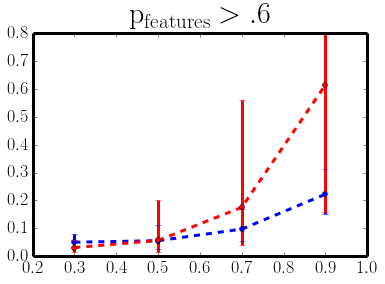

In [16]:
reds=[.3,.5,.7,.9]
plt.errorbar(reds,f8,yerr=(yl8,yh8),c='b',fmt='--o',lw=3,ms=5,label='uncorrected')
plt.errorbar(reds,f8_c,yerr=(yl8_c,yh8_c),c='r',fmt='--o',lw=3,ms=5,label='corrected')
plt.title('$\mathrm{p_{features}>.6}$',fontsize=30)
plt.xlim(.2,1)
plt.ylim(0,.8)

(0, 0.8)

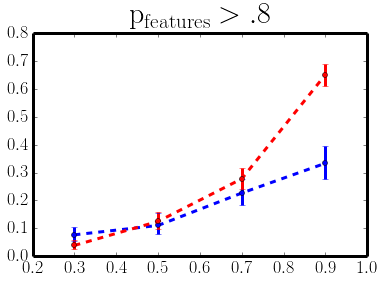

In [38]:
reds=[.3,.5,.7,.9]
plt.errorbar(reds,f8,yerr=(yl8,yh8),c='b',fmt='--o',lw=3,ms=5,label='uncorrected')
plt.errorbar(reds,f8_c,yerr=(yl8_c,yh8_c),c='r',fmt='--o',lw=3,ms=5,label='corrected')
plt.title('$\mathrm{p_{features}>.8}$',fontsize=30)
plt.xlim(.2,1)
plt.ylim(0,.8)

In [79]:
f8,yl8,yh8,Nr,Na=red_fraction_list(red_scatter_dct,red_scatter_dct_unc,all_scatter_dct,all_scatter_dct_unc,.6,30,'uncorrected')
f8_c,yl8_c,yh8_c,Nr_c,Na_c=red_fraction_list(red_scatter_dct,red_scatter_dct_unc,all_scatter_dct,all_scatter_dct_unc,.6,30,'corrected')

(0, 1)

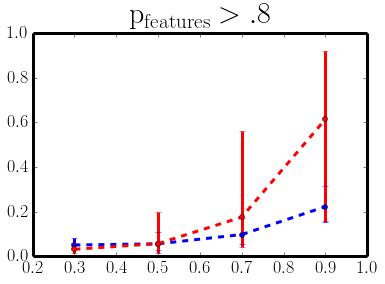

In [97]:
reds=[.3,.5,.7,.9]
plt.errorbar(reds,f8,yerr=(yl8,yh8),c='b',fmt='--o',lw=3,ms=5,label='uncorrected')
plt.errorbar(reds,f8_c,yerr=(yl8_c,yh8_c),c='r',fmt='--o',lw=3,ms=5,label='corrected')
plt.title('$\mathrm{p_{features}>.8}$',fontsize=30)
plt.xlim(.2,1)
plt.ylim(0,1)

In [98]:
f8

[0.050156739811912224,
 0.055555555555555552,
 0.097087378640776698,
 0.22222222222222221]